In [1039]:
########## Importing necessary libraries

import numpy as np 
import pandas as pd
import os
import json
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline 
import tqdm
import time
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, recall_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfTransformer
import pickle

# Data Preprocessing

In [1045]:
data_df = pd.read_csv("E:\\train_data.csv")

In [1046]:
# Checking the glimpse of the data
print(f"Rows: {data_df.shape[0]}, Cols: {data_df.shape[1]}")

Rows: 2500, Cols: 3


In [1047]:
data_df.head(5)

,Unnamed: 0,text,category
0,1497,﻿ 日月 光华 - - Traffic _ Info 精华区 文章 阅读- - - ...,traffic
1,436,﻿ 日本 去年 海外 资产 和 负债额 均 创 ...,economic
2,736,﻿ 梁斌 黄胄 联袂 在 京 举办 画展新华社 ...,art
3,2673,﻿ 记者来信 ： 乱 降价 也 有害新华社 北京...,economic
4,2266,﻿ 巴解 愿同 叙利亚 和解新华社 开罗 ５ 月...,politics


In [681]:
#### Get the information of the data
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 3 columns):
Unnamed: 0    2500 non-null int64
text          2500 non-null object
category      2500 non-null object
dtypes: int64(1), object(2)
memory usage: 58.7+ KB


In [1048]:
### Checking the coung of all categories
data_df.category.value_counts()

politics       448
sports         400
economic       289
military       221
art            220
education      195
traffic        190
medical        181
environment    178
computer       178
Name: category, dtype: int64

In [1049]:
############  Regular expression for cleaning the data 

import re

REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def preprocess_reviews(reviews):
    reviews = REPLACE_NO_SPACE.sub("", reviews.lower())
    reviews = REPLACE_WITH_SPACE.sub(" ", reviews)
    reviews=re.sub("(\s\d+)","",reviews) 
    reviews = re.sub(r"[a-z]", "", reviews)
    reviews = re.sub(r"[_]", "", reviews)
    reviews = re.sub(r"[\"]", "", reviews)
    reviews = re.sub(r"[:]", "", reviews)
    reviews=re.sub(r'\W', ' ', reviews)
    reviews = re.sub(r'\s+', ' ', reviews, flags=re.I)
    return reviews


In [1050]:
######## Apply the regular expression on text column
data_df['text'] = data_df['text'].apply(lambda x: preprocess_reviews(x))

In [1051]:
data_df.head()


,Unnamed: 0,text,category
0,1497,日月 光华 精华区 文章 阅读 发信人 亮马 亮马 信 区 标 题 中华人民共和国 公路 ...,traffic
1,436,日本 去年 海外 资产 和 负债额 均 创 历史纪录新华社 东京 月 日电 日本 内阁 今...,economic
2,736,梁斌 黄胄 联袂 在 京 举办 画展新华社 北京 月 日电 记者 尹鸿祝 河北省 蠡县梁庄...,art
3,2673,记者来信 乱 降价 也 有害新华社 北京 月 日电 记者来信 乱 降价 也 有害新华社 记...,economic
4,2266,巴解 愿同 叙利亚 和解新华社 开罗 月 日电 巴勒斯坦解放组织 主席 阿拉法特 的 高级...,politics


In [1008]:
##### Checking text column for null value
print(f"Samples with text null: {data_df.loc[data_df['text'].isnull()].shape[0]}")

Samples with text null: 0


In [1009]:
##### Checking category column for null value
print(f"Samples with category null: {data_df.loc[data_df['category'].isnull()].shape[0]}")

Samples with category null: 0


In [1052]:
########## Function for checking graphical representation of categories in data

def plot_count(feature, title, df, size=1):
    f, ax = plt.subplots(1,1, figsize=(10*size,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))

    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    ax.set_xticklabels(ax.get_xticklabels());
    
    plt.show()

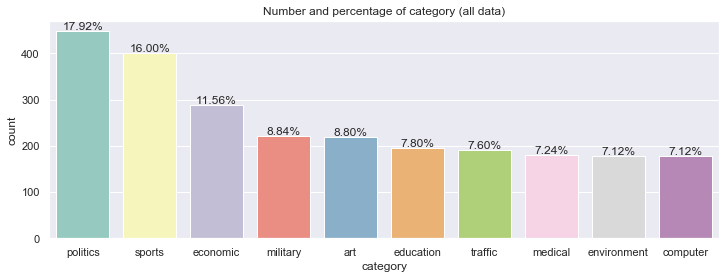

In [1053]:
plot_count('category', 'category (all data)', df=data_df,size=1.2)

In [1054]:
#### Creating the dependent variable class : convert text category to integer because machine learnign understand numbers ####
factor = pd.factorize(data_df['category'])
data_df.category = factor[0]
definitions = factor[1]
print(data_df.category.head(5))
print(definitions)

0    0
1    1
2    2
3    1
4    3
Name: category, dtype: int64
Index(['traffic', 'economic', 'art', 'politics', 'medical', 'computer',
       'military', 'sports', 'education', 'environment'],
      dtype='object')


# Feature engineering

In [1055]:
#### Splitting data in test and train set #####
train_df, test_df = train_test_split(data_df, test_size = 0.3, random_state = 42,shuffle=True)

In [1056]:
#### Verifying the Shape of the data
print(f"train: {train_df.shape}, test: {test_df.shape}")

train: (1750, 3), test: (750, 3)


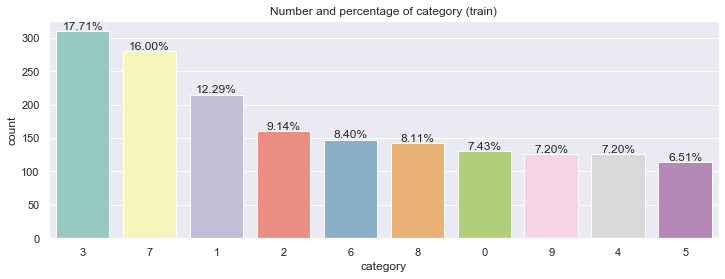

In [1057]:
##### Check if data in both test and train properly distributed   ###########

plot_count('category', 'category (train)', df=train_df,size=1.2)

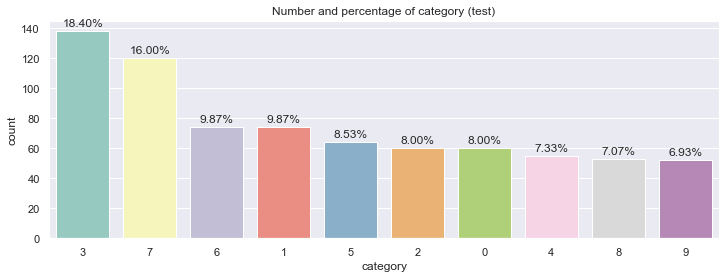

In [1058]:
plot_count('category', 'category (test)', df=test_df,size=1.2)

In [1059]:
####### CountVectorizer to create document of matrix ###########

def count_vect_feature(feature, df, max_features=5000):
    start_time = time.time()
    cv = CountVectorizer(max_features=max_features,
                             ngram_range=(1, 1),
                             stop_words='english')
    cv.fit(df[feature])
    
    
    
    
    # summarize
    print(cv.vocabulary_)
    # encode document
    X_feature = cv.transform(df[feature])
    # summarize encoded vector
    print(X_feature.shape)
    print(type(X_feature))
    print(X_feature.toarray())
    
    
    print('Count Vectorizer `{}` completed in {} sec.'.format(feature, round(time.time() - start_time,2)))
    return X_feature, cv

In [1060]:
###### Apply Countvectorizer #####
X_text, cv = count_vect_feature('text', train_df,max_features=1999)

{'全国': 336, '足球': 1797, '济南': 1337, '赛区': 1784, '日电': 1148, '记者': 1730, '今晚': 227, '比赛': 1300, '分钟': 411, '还有': 1827, '终于': 1577, '一场': 12, '战胜': 992, '参加': 518, '这个': 1830, '上海': 57, '广东': 870, '辽宁': 1809, '整个': 1103, '结束': 1590, '首都': 1981, '时代': 1153, '北京': 474, '离开': 1498, '音乐': 1955, '人们': 202, '感到': 959, '今天': 223, '举行': 150, '这位': 1833, '正是': 1283, '一位': 7, '时候': 1154, '江泽民': 1315, '总书记': 941, '希望': 847, '文化部': 1109, '单位': 492, '作为': 280, '中国': 116, '成立': 976, '我国': 981, '自己': 1645, '培养': 649, '代表': 236, '独特': 1397, '艺术': 1661, '感觉': 962, '创作': 415, '那里': 1884, '歌曲': 1277, '具有': 372, '广泛': 876, '影响': 921, '荣获': 1673, '国内': 615, '首次': 1979, '评选': 1748, '近年来': 1823, '为了': 133, '纪念': 1568, '先生': 327, '观众': 1704, '留下': 1443, '深刻': 1353, '话剧': 1752, '歌剧': 1276, '精神': 1557, '需要': 1943, '国家': 619, '民族': 1308, '水准': 1311, '突出': 1521, '尽管': 805, '得到': 927, '收到': 1074, '主席': 141, '完成': 755, '多年': 691, '大部分': 711, '经验': 1588, '理论': 1417, '尚未': 800, '个人': 110, '作品': 282, '音乐会': 1956, '全部': 

(1750, 1999)
<class 'scipy.sparse.csr.csr_matrix'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Count Vectorizer `text` completed in 1.77 sec.


In [1061]:
### Implement TF-IDF transformer
tfidfconverter = TfidfTransformer()
X_text = tfidfconverter.fit_transform(X_text)

In [1062]:
######## Splitting Data in train and validation set  #########

target =  'category'
X = X_text
y = train_df[target].values
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size = 0.20, random_state = 42,shuffle=True)

In [1063]:
train_X.shape, valid_X.shape, train_y.shape, valid_y.shape

((1400, 1999), (350, 1999), (1400,), (350,))

# Modelling Approach

In [1064]:
########## Creating model parameters for GridsearchCV. We can use multiple model
########## with diffrent params and after getting best model we can apply for final model

model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [1,10,20,30],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,5,10,50,100]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,2,3,4,5,10,11]
        }
    },
    'NaiveByes_regression' : {
        'model': MultinomialNB(fit_prior='true'),
        'params': {
           
        }
    },
    
}

In [1065]:
####### Implement GridSearchCV for finding best model ###########
from sklearn.model_selection import GridSearchCV
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(train_X, train_y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df_best = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df_best

,model,best_score,best_params
0,svm,0.893571,"{'C': 10, 'kernel': 'linear'}"
1,random_forest,0.858571,{'n_estimators': 100}
2,logistic_regression,0.902143,{'C': 11}
3,NaiveByes_regression,0.852857,{}


In [ ]:
###### Method for showing confusion matrix ########

def show_confusion_matrix(valid_y, predicted, size=1, trim_labels=False):
    mat = confusion_matrix(valid_y, predicted)
    plt.figure(figsize=(4*size, 4*size))
    f, ax = plt.subplots(1,1, figsize=(4*size,4*size))
    sns.set()
    target_labels = np.unique(valid_y)
    if(trim_labels):
        target_labels = [x[0:70] for x in target_labels]
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=target_labels,
                yticklabels=target_labels
               )
    ax.set_xticklabels(ax.get_xticklabels());
    ax.set_yticklabels(ax.get_yticklabels());
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()

In [1066]:
########## Logistics model : Because Gridsearch cv results best model is Logistics model ###########

%time
clf_logistics = LogisticRegression(C=11,solver='liblinear',multi_class='auto')
clf_logistics = clf_logistics.fit(train_X, train_y)

Wall time: 0 ns


In [1067]:
# save the model to disk

filename = 'finalized_model_logistics_Regression.pkl'
pickle.dump(clf_logistics, open(filename, 'wb'))


In [1068]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

Valid:
Feature: category 	| Prediction accuracy: 0.9314285714285714
Feature: category 	| Prediction F1-score: 0.9305670951604063
Feature: category 	| Prediction recall: 0.9314285714285714


<Figure size 432x432 with 0 Axes>

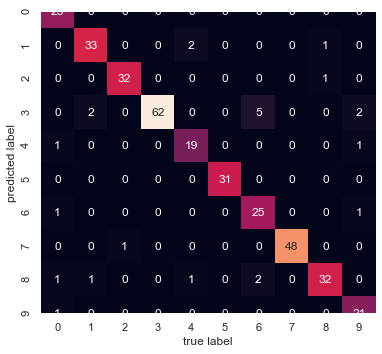

              precision    recall  f1-score   support

           0       1.00      0.85      0.92        27
           1       0.92      0.92      0.92        36
           2       0.97      0.97      0.97        33
           3       0.87      1.00      0.93        62
           4       0.90      0.86      0.88        22
           5       1.00      1.00      1.00        31
           6       0.93      0.78      0.85        32
           7       0.98      1.00      0.99        48
           8       0.86      0.94      0.90        34
           9       0.95      0.84      0.89        25

    accuracy                           0.93       350
   macro avg       0.94      0.92      0.93       350
weighted avg       0.93      0.93      0.93       350



In [1069]:
########## Getting the prediction from above loaded model and check the accuracy and other parameters
######### performed better, with weighted and macro average scores for performance, recall and f1-score 
######### (and corresponding scores per class)


predicted_valid = loaded_model.predict(valid_X)
prediction_acc = np.mean(predicted_valid == valid_y)
prediction_f1_score = f1_score(valid_y, predicted_valid, average='weighted')
prediction_recall = recall_score(valid_y, predicted_valid, average='weighted')
print("Valid:\n========================================================")
print(f"Feature: {target} \t| Prediction accuracy: {prediction_acc}")
print(f"Feature: {target} \t| Prediction F1-score: {prediction_f1_score}")
print(f"Feature: {target} \t| Prediction recall: {prediction_recall}")
show_confusion_matrix(valid_y, predicted_valid,size=1.5)
print(classification_report(valid_y, predicted_valid))

In [1072]:
##########  So we got the accuracy 93% . Which is good . We can use this model now ##############
##########  We can also use Deep learning for this classification with BERT but the dataset is very small and in deep learning 
########### we should have huge data for better accuracy